In [8]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import device_put
import numpy as np

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [14]:
import matplotlib.pyplot as plt

JAX arrays are immutable i.e. they cannot be modified on the fly

In [3]:
x = jnp.arange(10.)
x[5] = 10

TypeError: '<class 'jax.interpreters.xla._DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?

The workaround for this is the at[:].set(k) command. Enables slicing. Works with multidimensional arrays

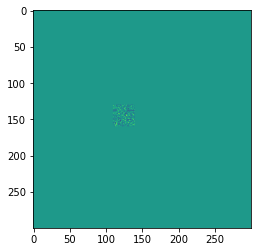

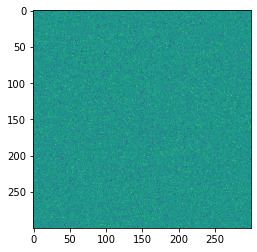

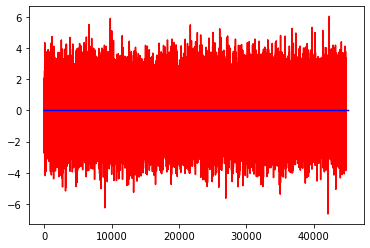

In [43]:
x = x.at[5].set(3.45)
x2 = x.at[3:7].set(np.random.rand(4))

key = random.PRNGKey(0)
key2 = random.PRNGKey(10)
size = 300
x_jnp1 = random.normal(key, (size, size), dtype=jnp.float32)
x_jnp2 = x_jnp1.at[130:160, 110:140].set(random.normal(key, (30, 30), dtype=jnp.float32))

plt.figure()
plt.imshow(x_jnp1 - x_jnp2)
plt.show()

mask = np.random.randint(0, 2, size=(size, size)).astype('bool')
_arr = random.normal(key2, (size, size), dtype=jnp.float32)
x_jnp3 = x_jnp1.at[mask].set(_arr[mask])

plt.figure()
plt.imshow(x_jnp1 - x_jnp3)
plt.show()

plt.figure()
plt.plot(x_jnp1[mask] - x_jnp3[mask], 'r')
plt.plot(x_jnp1[~mask] - x_jnp3[~mask], 'b')
plt.show()


45177

In [79]:
def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

def get_negatives(x):
    return x[x < 0]

def get_negpos(x):
    mask_pos = x < 0
    mask_pos = np.array(mask_pos)
    print(mask_pos)
    x1 = x[mask_pos]*2.5
    x2 = x[~mask_pos]*1.5
    print(x1)
    print(x2)
    x[mask_pos] = x1
    x[~mask_pos] = x2
    return jnp.array(x_np)

def get_negpos_where(x):
    mask_pos = x < 0
    x2 = jnp.where(mask_pos, x*2.5, x*0.5)
    return x2

In [24]:
norm_jit = jit(norm)
np.random.seed(1701)

X_np = np.random.rand(1000, 10)
X_jnp = jnp.array(X_np)
np.allclose(norm(X_jnp), norm_jit(X_jnp), atol=1e-12)

# runs on the CPU
time_np = %timeit -o norm(X_np)
time_jnp = %timeit -o norm(X_jnp)
time_jnp_jit = %timeit -o norm_jit(X_jnp)
time_jnp_jit2 = %timeit -o norm_jit(X_jnp).block_until_ready()

# printing compute times
print(f'-------------------------------------------')
print(f'[ np,     ] T = {time_np.average:.3e} s; speedup = {time_np.average/time_np.average:.2f}X')
print(f'[jnp,     ] T = {time_jnp.average:.3e} s; speedup = {time_np.average/time_jnp.average:.2f}X')
print(f'[jnp, jit ] T = {time_jnp_jit.average:.3e} s; speedup = {time_np.average/time_jnp_jit.average:.2f}X')
print(f'[jnp, jitb] T = {time_jnp_jit2.average:.3e} s; speedup = {time_np.average/time_jnp_jit2.average:.2f}X')


173 µs ± 243 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.75 ms ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
95.3 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
103 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-------------------------------------------
[ np,     ] T = 1.728e-04 s; speedup = 1.00X
[jnp,     ] T = 3.753e-03 s; speedup = 0.05X
[jnp, jit ] T = 9.529e-05 s; speedup = 1.81X
[jnp, jitb] T = 1.026e-04 s; speedup = 1.68X


In [81]:
x = jnp.array(np.random.randn(10))
get_negatives(x)
# jit(get_negatives)(x) #--> throws an error: static arrays needed
#jit(get_negpos)(x) #--> throws error: static arrays needed
jit(get_negpos_where)(x)

DeviceArray([ 0.6109363 ,  0.4170806 , -1.7942894 , -2.3376884 ,
             -2.6102133 , -1.7023052 , -2.8065274 , -5.298159  ,
             -0.13819733, -3.129597  ], dtype=float32)

In [52]:
norm_jit(np.random.randn(10))
norm_jit(np.random.randn(100))

DeviceArray([-0.1702575 ,  0.09049061, -0.92728513,  1.3003466 ,
              1.0581661 , -1.6809007 ,  0.373333  ,  1.0706303 ,
             -0.39437625,  0.8955079 ,  1.2520437 ,  0.25418353,
             -0.5103893 ,  0.754366  ,  0.81492823, -0.22554284,
              0.79001045, -0.9133518 ,  1.7769959 ,  1.0006096 ,
             -0.245772  , -0.0443899 ,  0.58067095, -1.1721942 ,
             -0.2890771 ,  1.6232225 ,  0.2512536 , -0.71941596,
             -0.42734838, -0.64756244,  0.01171546,  0.60575086,
              1.07421   ,  1.0847868 , -0.25668848, -0.01413786,
              1.5144122 , -1.6758363 ,  1.3108679 , -1.7545534 ,
              1.9600073 , -1.9333609 ,  0.8152483 ,  0.82770383,
              0.4216684 , -0.73230374, -1.3003739 , -0.01944445,
             -1.1292466 , -1.1641078 ,  0.697633  , -1.6349213 ,
             -0.64390635, -0.3683862 ,  1.3190907 , -1.0578766 ,
             -1.3463721 , -0.7684329 ,  1.5509686 , -0.4038367 ,
              0.32410514,

In [60]:
@jit
def f(x, y):
  print("Running f() :")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

Running f() :
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray([3.369481 , 2.4698713, 6.7151775], dtype=float32)

In [62]:
f(np.random.randn(4, 5), np.random.randn(5))

Running f() :
  x = Traced<ShapedArray(float32[4,5])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray([ 0.6793407 ,  1.9281973 , -0.5510749 ,  0.81946784], dtype=float32)